## TUIA - Aprendizaje Automático 1 - 2023

### Trabajo Práctico: Predicción de lluvia en Australia.

### Integrantes:
- Ponce, Daniel
- Yañez, Mirian

El presente informe detalla el trabajo práctico llevado a cabo para la predicción de las condiciones climáticas en Australia, centrándonos en las ciudades de Sydney, SydneyAirport, Canberra, Melbourne y MelbourneAirport. 

El conjunto de datos utilizado se denomina weatherAUS.csv y contiene información climática de los últimos diez años.

## Variables de Interés:

**RainTomorrow y RainfallTomorrow**: Estas variables representan nuestro objetivo de predicción, indicando si lloverá al día siguiente y la cantidad de lluvia, respectivamente.

"RainTomorrow" (categórica, para un problema de clasificación)

"RainfallTomorrow" (continua, para un problema de regresión).

## Paquetes y Librerias

In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append("code")
current_dir = os.path.dirname(os.path.realpath('__file__'))
data_source = os.path.join(current_dir, 'data', 'weatherAUS.csv')

from cleaning.clean import Clean
from regresion_lineal.regresion import RegressionLineal
from shap_analyzer.shap_analyzer import SHAPAnalyzer
from modelo_base.regression import RegresionModelBase
from modelo_base.clasification import ClasificacionModelBase
from neural_network.classification_neural import ClassificationNeuralNetwork
from neural_network.regression_neural import RegressionNeuralNetwork
from common import split_dataset


2024-02-26 17:58:20.361636: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### **Convertimos en variables numéricas las columnas 'RainToday' y 'RainTomorrow'**

In [2]:
df = pd.read_csv(data_source)
df["Date"]=pd.to_datetime(df["Date"])
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

# 2) Análisis descriptivo

In [3]:
df.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [4]:
df.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0.0,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0.0,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0.0,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,0.0,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.0,0.2


In [5]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145412 entries, 0 to 145411
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0        145412 non-null  int64         
 1   Date              145412 non-null  datetime64[ns]
 2   Location          145412 non-null  object        
 3   MinTemp           143928 non-null  float64       
 4   MaxTemp           144159 non-null  float64       
 5   Rainfall          142152 non-null  float64       
 6   Evaporation       82658 non-null   float64       
 7   Sunshine          75616 non-null   float64       
 8   WindGustDir       135096 non-null  object        
 9   WindGustSpeed     135159 non-null  float64       
 10  WindDir9am        134850 non-null  object        
 11  WindDir3pm        141186 non-null  object        
 12  WindSpeed9am      143645 non-null  float64       
 13  WindSpeed3pm      142351 non-null  float64       
 14  Humi

Unnamed: 0              0
Date                    0
Location                0
MinTemp              1484
MaxTemp              1253
Rainfall             3260
Evaporation         62754
Sunshine            69796
WindGustDir         10316
WindGustSpeed       10253
WindDir9am          10562
WindDir3pm           4226
WindSpeed9am         1767
WindSpeed3pm         3061
Humidity9am          2653
Humidity3pm          4505
Pressure9am         15061
Pressure3pm         15024
Cloud9am            55870
Cloud3pm            59336
Temp9am              1766
Temp3pm              3607
RainToday            3260
RainTomorrow         3259
RainfallTomorrow     3259
dtype: int64

### **Hay un total de 145412 datos, se puede observar que hay datos nulos.**

## Filtramos por las ciudades de interés

In [6]:
ciudades = ['Sydney', 'SydneyAirport', 'Canberra', 'Melbourne', 'MelbourneAirport']
df = df[df['Location'].isin(ciudades)]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15986 entries, 30167 to 70370
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0        15986 non-null  int64         
 1   Date              15986 non-null  datetime64[ns]
 2   Location          15986 non-null  object        
 3   MinTemp           15495 non-null  float64       
 4   MaxTemp           15500 non-null  float64       
 5   Rainfall          15199 non-null  float64       
 6   Evaporation       14280 non-null  float64       
 7   Sunshine          14038 non-null  float64       
 8   WindGustDir       14529 non-null  object        
 9   WindGustSpeed     14531 non-null  float64       
 10  WindDir9am        15291 non-null  object        
 11  WindDir3pm        15696 non-null  object        
 12  WindSpeed9am      15725 non-null  float64       
 13  WindSpeed3pm      15737 non-null  float64       
 14  Humidity9am       

In [7]:
df = df.dropna(subset=['RainTomorrow', 'RainfallTomorrow', 'Humidity3pm', 'Rainfall'])
df['Cloud3pm'] = df.groupby('Location')['Cloud3pm'].transform(lambda x: x.fillna(x.median()))

df.isna().sum()

# los eliminmos porque son el 5% de los dataset

Unnamed: 0             0
Date                   0
Location               0
MinTemp                8
MaxTemp                5
Rainfall               0
Evaporation         1675
Sunshine            1926
WindGustDir         1432
WindGustSpeed       1430
WindDir9am           670
WindDir3pm           283
WindSpeed9am         259
WindSpeed3pm         244
Humidity9am           68
Humidity3pm            0
Pressure9am          249
Pressure3pm          232
Cloud9am            1890
Cloud3pm               0
Temp9am               20
Temp3pm                0
RainToday              0
RainTomorrow           0
RainfallTomorrow       0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14993 entries, 30167 to 70370
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0        14993 non-null  int64         
 1   Date              14993 non-null  datetime64[ns]
 2   Location          14993 non-null  object        
 3   MinTemp           14985 non-null  float64       
 4   MaxTemp           14988 non-null  float64       
 5   Rainfall          14993 non-null  float64       
 6   Evaporation       13318 non-null  float64       
 7   Sunshine          13067 non-null  float64       
 8   WindGustDir       13561 non-null  object        
 9   WindGustSpeed     13563 non-null  float64       
 10  WindDir9am        14323 non-null  object        
 11  WindDir3pm        14710 non-null  object        
 12  WindSpeed9am      14734 non-null  float64       
 13  WindSpeed3pm      14749 non-null  float64       
 14  Humidity9am       

### Ahora contamos con un total de 15986 datos.

### Cantidad de valores faltantes:

In [9]:
df.isna().sum()

Unnamed: 0             0
Date                   0
Location               0
MinTemp                8
MaxTemp                5
Rainfall               0
Evaporation         1675
Sunshine            1926
WindGustDir         1432
WindGustSpeed       1430
WindDir9am           670
WindDir3pm           283
WindSpeed9am         259
WindSpeed3pm         244
Humidity9am           68
Humidity3pm            0
Pressure9am          249
Pressure3pm          232
Cloud9am            1890
Cloud3pm               0
Temp9am               20
Temp3pm                0
RainToday              0
RainTomorrow           0
RainfallTomorrow       0
dtype: int64

### Estadística descriptiva de las variables numéricas

In [10]:
df.describe()

,Unnamed: 0,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
count,14993.000000,14985.000000,14988.000000,14993.000000,13318.000000,13067.000000,13563.000000,14734.000000,14749.000000,14925.000000,14993.000000,14744.000000,14761.000000,13103.000000,14993.000000,14973.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,48360.978857,11.610397,21.796918,2.303728,4.878946,6.906130,44.289464,16.445364,21.731236,68.881407,51.239645,1018.335153,1016.077975,4.738304,4.757954,15.584292,20.273154,0.232709,0.229040,2.252278
std,14822.983185,5.889194,6.053972,7.412942,3.056983,3.837161,14.947313,10.261409,9.530939,15.649304,17.757028,7.404186,7.267747,2.731254,2.415661,5.572528,5.858013,0.422572,0.420229,7.326791
min,30176.000000,-8.000000,4.100000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,11.000000,3.000000,986.700000,985.500000,0.000000,0.000000,-1.300000,3.700000,0.000000,0.000000,0.000000
25%,33951.000000,7.900000,17.200000,0.000000,2.600000,3.800000,33.000000,9.000000,15.000000,59.000000,39.000000,1013.400000,1011.200000,2.000000,3.000000,11.600000,16.000000,0.000000,0.000000,0.000000
50%,46774.000000,11.600000,21.300000,0.000000,4.200000,7.600000,43.000000,15.000000,20.000000,70.000000,51.000000,1018.500000,1016.300000,6.000000,5.000000,15.500000,19.800000,0.000000,0.000000,0.000000
75%,65741.000000,15.900000,25.800000,0.800000,6.600000,10.000000,54.000000,22.000000,28.000000,80.000000,62.000000,1023.300000,1021.000000,7.000000,7.000000,19.600000,24.200000,0.000000,0.000000,0.800000
max,70391.000000,30.500000,46.800000,119.400000,23.800000,13.900000,122.000000,69.000000,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,37.200000,46.100000,1.000000,1.000000,119.400000


### Analizamos nuestra variable objetivo, la que queremos predecir para saber si el df esta balanceado o no.

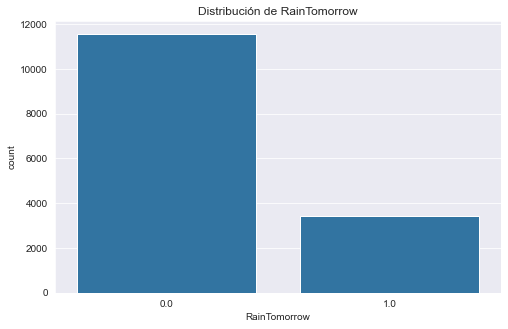

In [11]:
plt.figure(figsize=(8, 5))
sns.countplot(x='RainTomorrow', data=df)
plt.title('Distribución de RainTomorrow')
plt.show()

### Se puede observar que el dataset no está balanceado

### Histogramas

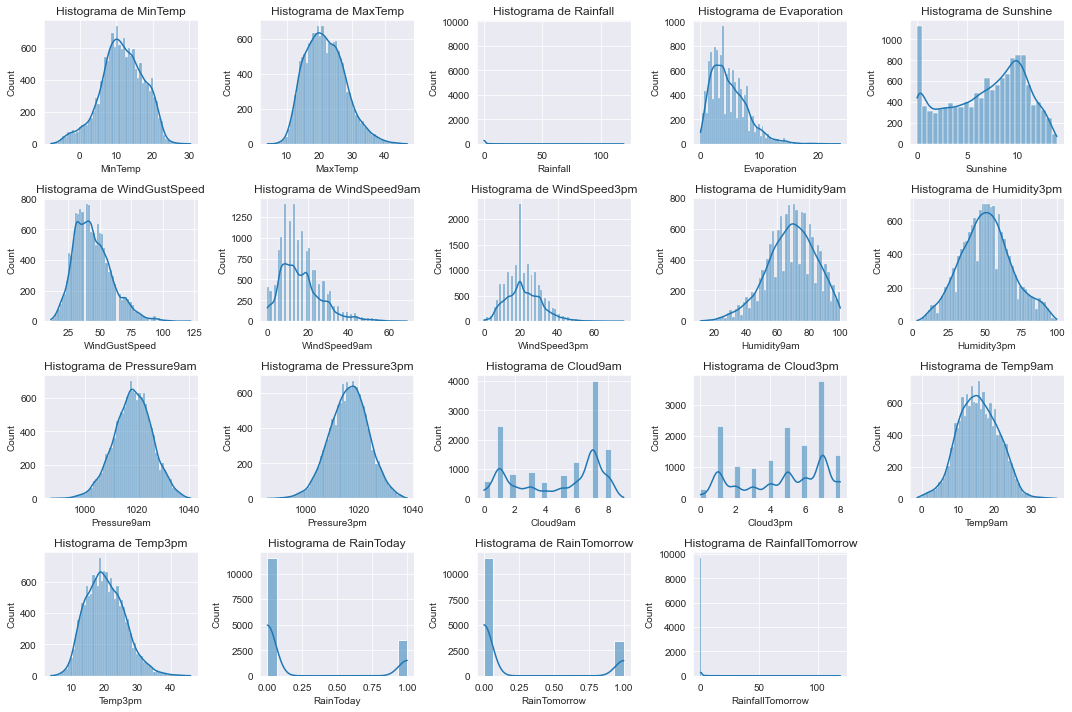

In [12]:
numeric_columns = df.select_dtypes(include=[np.float64]).columns

plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 5, i)
    sns.histplot(df[column].dropna(), kde=True)
    plt.title(f'Histograma de {column}')

plt.tight_layout()
plt.show()


# Matriz de correlación 

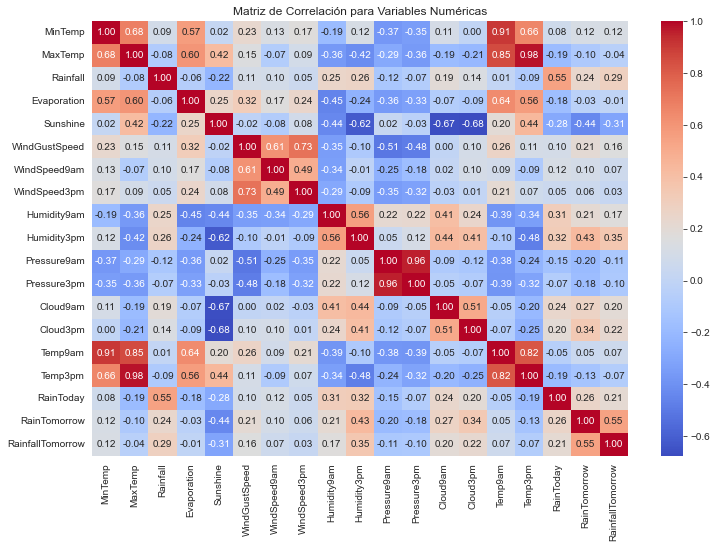

In [13]:
correlation_matrix_numeric = df[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación para Variables Numéricas')
plt.show()


Podemos observar que las variables con mayor correlación con RainfallTomorrow son:

*   Humidity3pm (0.35)
*   Rainfall (0.29)
*   Cloud3pm (0.25)
*   Sunshine (-0.31)

y las variables con mayor correlación con RainTomorrow son:

*   Humidity3pm (0,42)
*   Cloud3pm (0.37)
*   Rainfall (0,24)
*   Sunshine (-0,43)

## Realizamos el split de entrenamiento y prueba

In [14]:
location_mapping = {'Canberra': 0, 'Melbourne': 1, 'MelbourneAirport': 2, 'Sydney': 3, 'SydneyAirport': 4}
df['Location___']=df['Location'].map(location_mapping)
df['Location']=df['Location___']
_x_train, _x_test, _y_train_regression, _y_test_regression, _y_train_classification, _y_test_classification = split_dataset(df)

## Realizamos la limpieza en la clase clean y volvemos a visualizar los datos

### En esta parte implementamos en simultaneo las siguientes consignas:

* Implementar la solución del problema de regresión con regresión lineal múltiple.

* Optimizar la selección de hiperparámetros.

* Implementar explicabilidad del modelo. SHAP


In [15]:
regresion_clasic = RegressionLineal()
x_test, y_test_regression, y_pred, modelo = regresion_clasic.classic(_x_train, _x_test, _y_train_regression, _y_test_regression)
print(f"Métricas del modelo Regresion lineal clasic:")
regresion_clasic.metrics(y_test_regression, y_pred)

Métricas del modelo Regresion lineal clasic:
MSE: 44.64635910356854
R^2: 0.24142810860735353
RMSE: 6.681793105414784
MAE: RainfallTomorrow    3.154499
dtype: float64
MAPE: RainfallTomorrow    inf
dtype: float64


In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'


In [16]:
#aplicamos validación cruzada
regresion_clasic.cross_validate(_y_test_regression, _y_test_regression, modelo, cv=5)

Mean Squared Error (CV): 7.501424879226929e-28
R^2 Score (CV): 1.0
Mean Absolute Error (CV): 1.1210883283173034e-14


(7.501424879226929e-28, 1.0, 1.1210883283173034e-14)

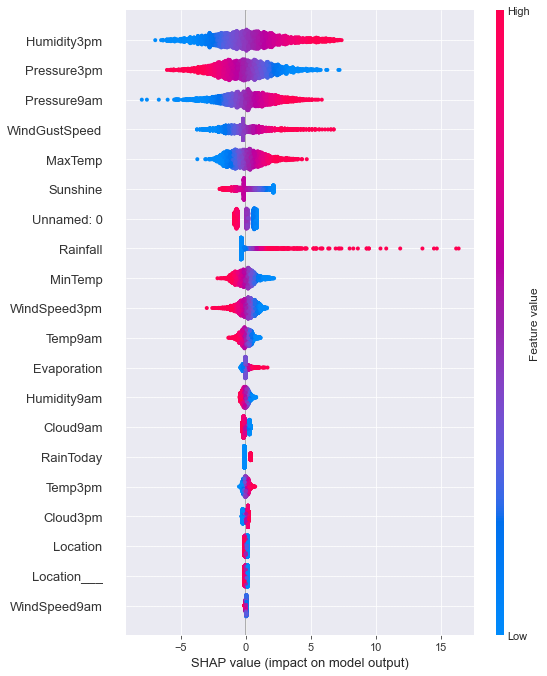

In [17]:
try:
    shap_analyzer = SHAPAnalyzer(modelo, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [18]:
print('métodos de gradiente descendiente')
regresion_gradient_desecent = RegressionLineal()
x_test, y_test, y_pred, modelo = regresion_gradient_desecent.gradient_descent(_x_train, _x_test, _y_train_regression, _y_test_regression)
print(f"Métricas del Modelo:")
regresion_gradient_desecent.metrics(y_test, y_pred)


métodos de gradiente descendiente
Métricas del Modelo:
MSE: 60.974449333432744
R^2: -0.03599720752571223
RMSE: 7.808613790771877
MAE: 3.6818724219556245
MAPE: nan


In [19]:
#aplicamos validación cruzada
regresion_gradient_desecent.cross_validate(x_test, y_test, modelo, cv=5)

Mean Squared Error (CV): 56.00568437211071
R^2 Score (CV): 0.04842547576301992
Mean Absolute Error (CV): 4.308963589321821


(56.00568437211071, 0.04842547576301992, 4.308963589321821)

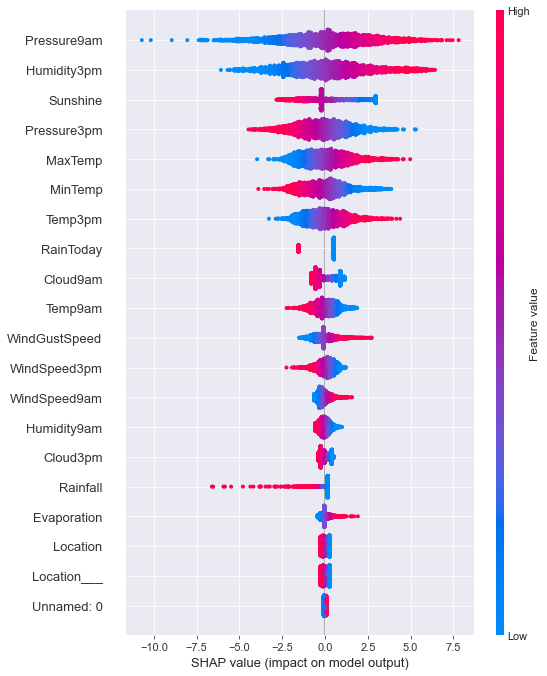

In [20]:
try:
    shap_analyzer = SHAPAnalyzer(modelo, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [21]:
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}


regresion_gradient_descent = RegressionLineal()
x_test, y_test, y_pred, best_model = regresion_gradient_descent.gradient_descent_optimize_hyperparameters(param_grid,
                                                                                                          _x_train, _x_test, _y_train_regression, _y_test_regression)

regresion_gradient_descent.metrics(y_test, y_pred)

MSE: 55.597594910370454
R^2: 0.05535919221975483
RMSE: 7.456379477358328
MAE: 4.634563816605749
MAPE: nan


## Regresión lineal de Lasso

In [22]:
# regresion de Lasso
regresion_lasso = RegressionLineal()
x_test, y_test, y_pred, modelo = regresion_lasso.lasso_regression(_x_train, _x_test, _y_train_regression, _y_test_regression)


Metricas lasso
MSE: 50.3556882270363
R^2: 0.14442273843315057
RMSE: 7.096174196497455
MAE: 3.06787831940944
MAPE: inf


In [23]:
#aplicamos validación cruzada
regresion_lasso.cross_validate(x_test, y_test, modelo, cv=5)

Mean Squared Error (CV): 49.54782967793468
R^2 Score (CV): 0.15814880254843822
Mean Absolute Error (CV): 3.120381311710289


(49.54782967793468, 0.15814880254843822, 3.120381311710289)

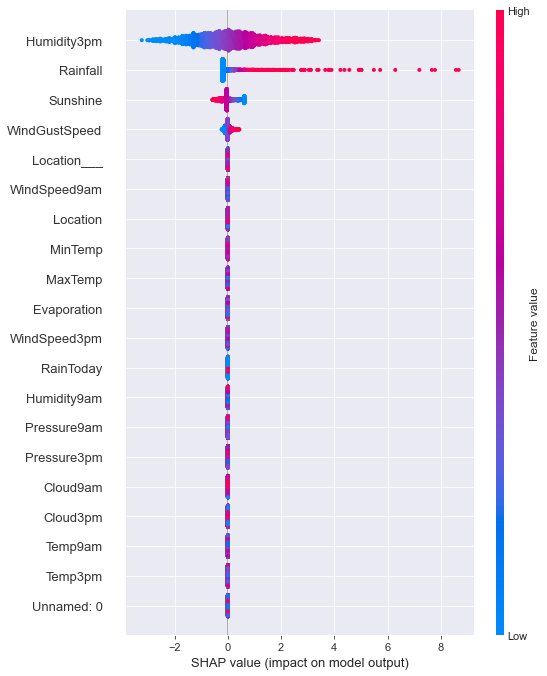

In [24]:
try:
    shap_analyzer = SHAPAnalyzer(modelo, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [25]:
# Crear una instancia de la clase RegressionLineal
regresion_lineal = RegressionLineal()

# Definir el rango de valores para el hiperparámetro alpha
param_grid_lasso = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

# Llamar al método optimize_hyperparameters para Lasso
x_test, y_test, y_pred_lasso, best_lasso_model = regresion_lineal.optimize_hyperparameters_(
    model_name='Lasso',
    param_grid=param_grid_lasso,
    _x_train=_x_train,
    _x_test=_x_test,
    _y_train_regression=_y_train_regression,
    _y_test_regression=_y_test_regression
)

# Calcular métricas
metricas_lasso = regresion_lineal.metrics(y_test, y_pred_lasso)

# Imprimir métricas y mejores hiperparámetros para Lasso
print(f"Métricas del mejor modelo Lasso:")
print(metricas_lasso)
print("Mejores hiperparámetros para Lasso:", best_lasso_model.get_params())


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


{'alpha': 0.001}
MSE: 44.64796416298223
R^2: 0.2414008375604041
RMSE: 6.681913211272819
MAE: 3.152909490965672
MAPE: inf
Métricas del mejor modelo Lasso:
None
Mejores hiperparámetros para Lasso: {'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


## Regresión lineal de Ridge

In [26]:
# regresion de Ridge
regresion_ridge = RegressionLineal()
x_test, y_test, y_pred, ridge_model = regresion_ridge.ridge_regression(_x_train, _x_test, _y_train_regression, _y_test_regression)
print(_y_test_regression.isna().sum())
print(_y_train_regression.isna().sum())

regresion_lasso.metrics(y_test, y_pred)


RainfallTomorrow    0
dtype: int64
RainfallTomorrow    0
dtype: int64
MSE: 44.64639183737677
R^2: 0.24142755243777292
RMSE: 6.681795554892171
MAE: RainfallTomorrow    3.154295
dtype: float64
MAPE: RainfallTomorrow    inf
dtype: float64


In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'


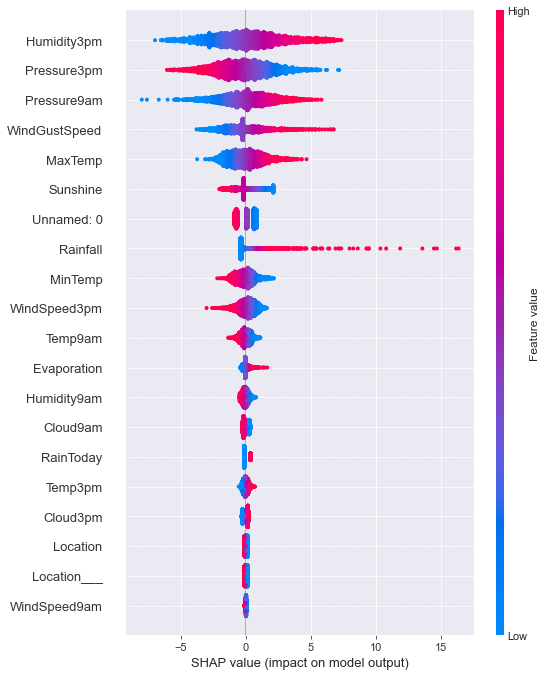

In [27]:
try:
    shap_analyzer = SHAPAnalyzer(ridge_model, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

## Regresión lineal de Elasticnet

In [28]:
# regresion de Elasticnet
regresion_elasticnet = RegressionLineal()
x_test, y_test, y_pred, elasticnet_model = regresion_elasticnet.elasticnet_regression(_x_train, _x_test, _y_train_regression, _y_test_regression)
print(f"Métricas del modelo Regresion lineal Elasticnet:")
regresion_elasticnet.metrics(y_test, y_pred)

Métricas del modelo Regresion lineal Elasticnet:
MSE: 48.986176946295046
R^2: 0.16769166300784055
RMSE: 6.999012569376844
MAE: 2.962752394122789
MAPE: inf


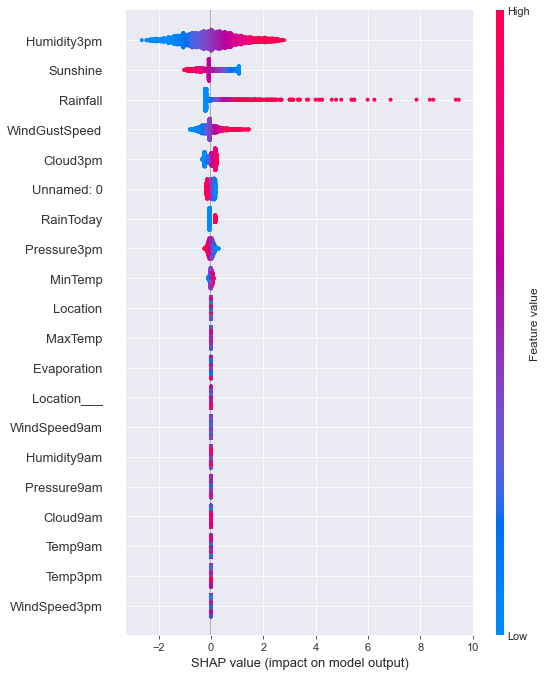

In [29]:
try:
    shap_analyzer = SHAPAnalyzer(elasticnet_model, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [30]:
regresion_lineal = RegressionLineal()

# Definir el rango de valores para el hiperparámetro alpha
param_grid_Elasticnet = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # Puedes ajustar estos valores según sea necesario
}
# Llamar al método optimize_hyperparameters para Lasso
x_test, y_test, y_pred_elasticnet, best_lasso_model = regresion_lineal.optimize_hyperparameters_('ElasticNet', param_grid_Elasticnet, _x_train, _x_test, _y_train_regression, _y_test_regression)

# Calcular métricas
metricas_elasticnet = regresion_lineal.metrics(y_test, y_pred_elasticnet)

# Imprimir métricas y mejores hiperparámetros para Lasso
print(f"Métricas del mejor modelo Elasticnet:")
print(metricas_elasticnet)
print("Mejores hiperparámetros para Elasticnet:", best_lasso_model.get_params())

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.874e+03, tolerance: 4.968e+01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.035e+03, tolerance: 4.950e+01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.348e+03, tolerance: 5.079e+01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.438e+03, tolerance: 5.042e+01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.846e+03, tolerance: 5.088e+01
Objective did n

{'l1_ratio': 0.7, 'alpha': 0.001}
MSE: 44.64758644545985
R^2: 0.24140725523703244
RMSE: 6.681884947038512
MAE: 3.152679668046751
MAPE: inf
Métricas del mejor modelo Elasticnet:
None
Mejores hiperparámetros para Elasticnet: {'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.7, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.358e+02, tolerance: 6.282e+01


## Regresión Logística

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Accuracy: 0.84
Precision: 0.75
Recall: 0.50
F1 Score: 0.60
ROC-AUC: 0.72
Matiz de confusión:
          pred: No  Pred: Si
Real: No      2150       120
Real: si       364       365


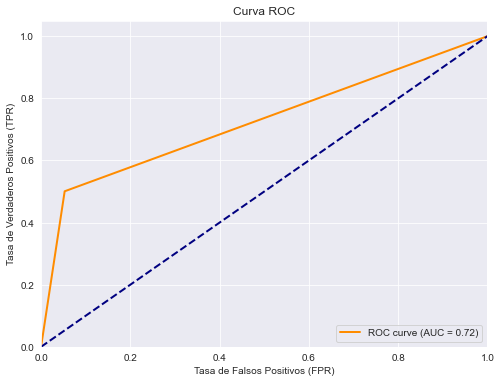

In [31]:
#regresion logistica
regression_logistic = RegressionLineal()
x_test, y_test, y_pred, modelo = regression_logistic.logistic(_x_train, _x_test, _y_train_classification, _y_test_classification)
regression_logistic.logic_metrics(y_test, y_pred)

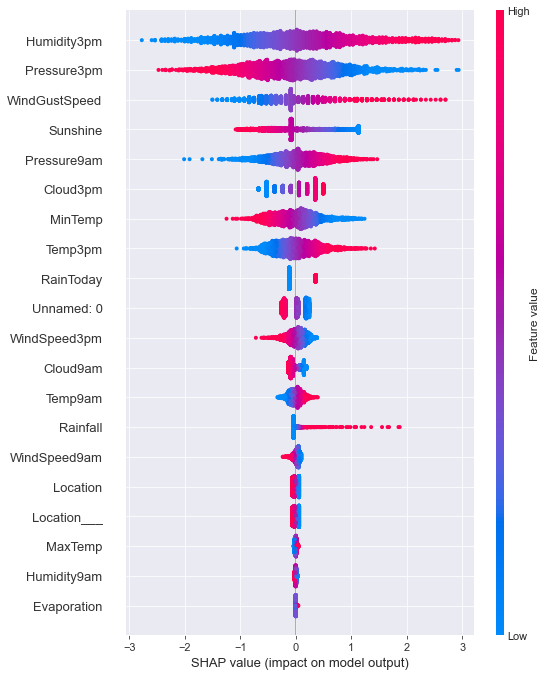

In [32]:
try:
    shap_analyzer = SHAPAnalyzer(modelo, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [33]:
regresion_lineal = RegressionLineal()
#buscando los hipperparametros
param_grid_logistic = {
    'C': [ 0.01, 0.1],
    'penalty': ['l1'],
    'solver': ['liblinear']
}
x_test_logistic, y_test_logistic, y_pred_logistic, best_logistic_model = regresion_lineal.optimize_hyperparameters_logistic(
    param_grid_logistic, _x_train, _x_test, _y_train_classification, _y_test_classification)

# Calcular métricas
print(f"Métricas del mejor modelo de regresión logística:")
regresion_lineal.metrics(y_test_logistic, y_pred_logistic)

# Imprimir métricas y mejores hiperparámetros para la regresión logística
print("Mejores hiperparámetros para la regresión logística:", best_logistic_model.get_params())


The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.


Métricas del mejor modelo de regresión logística:
MSE: 0.162054018006002
R^2: 0.11923641703377375
RMSE: 0.4025593347644568
MAE: 0.162054018006002
MAPE: nan
Mejores hiperparámetros para la regresión logística: {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


## Implementar un modelo base para clasificación y uno para regresión

Accuracy: 0.77
Precision: 0.66
Recall: 0.08
F1 Score: 0.14
ROC-AUC: 0.53
Matiz de confusión:
          pred: No  Pred: Si
Real: No      2240        30
Real: si       670        59


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


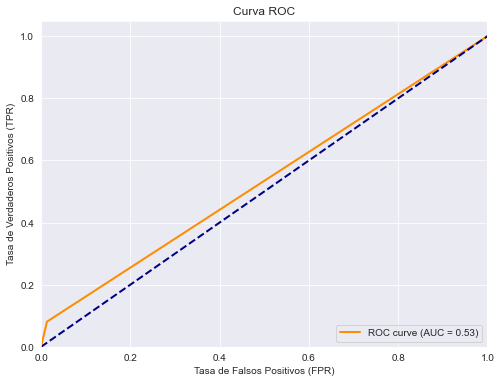

In [34]:
regression_logistic = ClasificacionModelBase()
x_test, y_test, y_pred, modelo = regression_logistic.logistic(_x_train[['Rainfall']], _x_test[['Rainfall']], _y_train_classification, _y_test_classification)
regression_logistic.logic_metrics(y_test, y_pred)

In [35]:

# Ejemplo de uso
# Suponiendo que tienes un DataFrame llamado 'data' con las columnas 'Temp3pm' y 'RainfallTomorrow'
modelo_regresion_base = RegresionModelBase()
modelo_entrenado, error_cuadratico_medio, coeficiente_determinacion = modelo_regresion_base.train(_x_train[['Rainfall']], _x_test[['Rainfall']], _y_train_regression, _y_test_regression)

# Mostrar métricas de rendimiento
print("Métricas de rendimiento:")
print(f"Error cuadrático medio (MSE): {error_cuadratico_medio:.2f}")
print(f"Coeficiente de determinación (R^2): {coeficiente_determinacion:.2f}")


Métricas de rendimiento:
Error cuadrático medio (MSE): 52.79
Coeficiente de determinación (R^2): 0.10


## Implementar las soluciones con una red neuronal

In [36]:
print('=============================clasificacion con redes neuronales================================================')
clf_nn = ClassificationNeuralNetwork()

# Entrenar y evaluar el modelo
clf_nn.classification(_x_train, _x_test, _y_train_classification, _y_test_classification)

# Visualizar las curvas de aprendizaje
clf_nn.plot_learning_curves(_x_train, _x_test, _y_train_classification, _y_test_classification)


[I 2024-02-26 17:58:45,147] A new study created in memory with name: no-name-f8183e15-1e87-41e9-818c-e6a13fe6eab4


=============================clasificacion con redes neuronales================================================
94/94 [==============================] - 0s 693us/step


[I 2024-02-26 17:58:49,275] Trial 0 finished with value: 0.17605868622874288 and parameters: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.0002277154914144271}. Best is trial 0 with value: 0.17605868622874288.


94/94 [==============================] - 0s 700us/step


[I 2024-02-26 17:58:53,023] Trial 1 finished with value: 0.24141380460153383 and parameters: {'num_layers': 1, 'n_units_l0': 1, 'learning_rate': 0.061551755689151576}. Best is trial 0 with value: 0.17605868622874288.


94/94 [==============================] - 0s 753us/step


[I 2024-02-26 17:58:57,949] Trial 2 finished with value: 0.18172724241413807 and parameters: {'num_layers': 2, 'n_units_l0': 10, 'n_units_l1': 15, 'learning_rate': 0.0006806551848946808}. Best is trial 0 with value: 0.17605868622874288.


94/94 [==============================] - 0s 693us/step


[I 2024-02-26 17:59:01,862] Trial 3 finished with value: 0.24308102700900303 and parameters: {'num_layers': 1, 'n_units_l0': 8, 'learning_rate': 0.03589623404737054}. Best is trial 0 with value: 0.17605868622874288.


94/94 [==============================] - 0s 688us/step


[I 2024-02-26 17:59:05,849] Trial 4 finished with value: 0.17972657552517501 and parameters: {'num_layers': 1, 'n_units_l0': 9, 'learning_rate': 0.008862085159783062}. Best is trial 0 with value: 0.17605868622874288.


94/94 [==============================] - 0s 810us/step


[I 2024-02-26 17:59:11,992] Trial 5 finished with value: 0.24308102700900303 and parameters: {'num_layers': 3, 'n_units_l0': 9, 'n_units_l1': 15, 'n_units_l2': 9, 'learning_rate': 0.02501074313462019}. Best is trial 0 with value: 0.17605868622874288.


94/94 [==============================] - 0s 836us/step


[I 2024-02-26 17:59:16,695] Trial 6 finished with value: 0.1853951317105702 and parameters: {'num_layers': 2, 'n_units_l0': 7, 'n_units_l1': 11, 'learning_rate': 0.0049752891690536365}. Best is trial 0 with value: 0.17605868622874288.


94/94 [==============================] - 0s 674us/step


[I 2024-02-26 17:59:20,439] Trial 7 finished with value: 0.20706902300766927 and parameters: {'num_layers': 1, 'n_units_l0': 1, 'learning_rate': 0.00019581988143344667}. Best is trial 0 with value: 0.17605868622874288.


94/94 [==============================] - 0s 746us/step


[I 2024-02-26 17:59:24,291] Trial 8 finished with value: 0.18639546515505168 and parameters: {'num_layers': 1, 'n_units_l0': 7, 'learning_rate': 0.00044188862149303096}. Best is trial 0 with value: 0.17605868622874288.


94/94 [==============================] - 0s 755us/step


[I 2024-02-26 17:59:29,023] Trial 9 finished with value: 0.355785261753918 and parameters: {'num_layers': 2, 'n_units_l0': 8, 'n_units_l1': 12, 'learning_rate': 1.405864667309777e-05}. Best is trial 0 with value: 0.17605868622874288.


94/94 [==============================] - 0s 824us/step


[I 2024-02-26 17:59:34,517] Trial 10 finished with value: 0.24308102700900303 and parameters: {'num_layers': 3, 'n_units_l0': 16, 'n_units_l1': 1, 'n_units_l2': 1, 'learning_rate': 6.661720566157776e-05}. Best is trial 0 with value: 0.17605868622874288.


94/94 [==============================] - 0s 689us/step


[I 2024-02-26 17:59:38,521] Trial 11 finished with value: 0.1593864621540514 and parameters: {'num_layers': 1, 'n_units_l0': 14, 'learning_rate': 0.003273432393705128}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 728us/step


[I 2024-02-26 17:59:42,543] Trial 12 finished with value: 0.16305435145048353 and parameters: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.0028474059892197186}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 789us/step


[I 2024-02-26 17:59:47,408] Trial 13 finished with value: 0.17972657552517501 and parameters: {'num_layers': 2, 'n_units_l0': 13, 'n_units_l1': 4, 'learning_rate': 0.003042083576368647}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 716us/step


[I 2024-02-26 17:59:51,487] Trial 14 finished with value: 0.16372124041347114 and parameters: {'num_layers': 1, 'n_units_l0': 13, 'learning_rate': 0.002051977511102434}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 770us/step


[I 2024-02-26 17:59:56,506] Trial 15 finished with value: 0.17872624208069354 and parameters: {'num_layers': 2, 'n_units_l0': 13, 'n_units_l1': 6, 'learning_rate': 0.0016368978068232798}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 696us/step


[I 2024-02-26 18:00:00,565] Trial 16 finished with value: 0.18006002000666887 and parameters: {'num_layers': 1, 'n_units_l0': 15, 'learning_rate': 0.008448476429329457}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 856us/step


[I 2024-02-26 18:00:06,434] Trial 17 finished with value: 0.23241080360120037 and parameters: {'num_layers': 3, 'n_units_l0': 12, 'n_units_l1': 8, 'n_units_l2': 16, 'learning_rate': 0.015190886650388829}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 708us/step


[I 2024-02-26 18:00:10,311] Trial 18 finished with value: 0.24308102700900303 and parameters: {'num_layers': 1, 'n_units_l0': 4, 'learning_rate': 0.09618935020181432}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 794us/step


[I 2024-02-26 18:00:15,056] Trial 19 finished with value: 0.23007669223074356 and parameters: {'num_layers': 2, 'n_units_l0': 11, 'n_units_l1': 1, 'learning_rate': 0.001126414286276897}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 764us/step


[I 2024-02-26 18:00:19,080] Trial 20 finished with value: 0.1733911303767922 and parameters: {'num_layers': 1, 'n_units_l0': 14, 'learning_rate': 0.003583725398202224}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 696us/step


[I 2024-02-26 18:00:23,103] Trial 21 finished with value: 0.1710570190063354 and parameters: {'num_layers': 1, 'n_units_l0': 14, 'learning_rate': 0.0019452834254418713}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 697us/step


[I 2024-02-26 18:00:27,915] Trial 22 finished with value: 0.1657219073024342 and parameters: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.004549327765346817}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 696us/step


[I 2024-02-26 18:00:31,918] Trial 23 finished with value: 0.17139046348782927 and parameters: {'num_layers': 1, 'n_units_l0': 12, 'learning_rate': 0.001516625463987917}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 746us/step


[I 2024-02-26 18:00:36,818] Trial 24 finished with value: 0.20340113371123703 and parameters: {'num_layers': 2, 'n_units_l0': 14, 'n_units_l1': 10, 'learning_rate': 0.009834421950257346}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 719us/step


[I 2024-02-26 18:00:40,838] Trial 25 finished with value: 0.16705568522840952 and parameters: {'num_layers': 1, 'n_units_l0': 15, 'learning_rate': 0.0008384661602513214}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 702us/step


[I 2024-02-26 18:00:44,808] Trial 26 finished with value: 0.17639213071023674 and parameters: {'num_layers': 1, 'n_units_l0': 11, 'learning_rate': 0.00251495601711095}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 707us/step


[I 2024-02-26 18:00:48,786] Trial 27 finished with value: 0.1750583527842614 and parameters: {'num_layers': 1, 'n_units_l0': 13, 'learning_rate': 0.005117477884995478}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 764us/step


[I 2024-02-26 18:00:53,644] Trial 28 finished with value: 0.1790596865621874 and parameters: {'num_layers': 2, 'n_units_l0': 15, 'n_units_l1': 4, 'learning_rate': 0.0020288633958265075}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 715us/step


[I 2024-02-26 18:00:57,668] Trial 29 finished with value: 0.16838946315438474 and parameters: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.00045906510623082875}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 701us/step


[I 2024-02-26 18:01:01,532] Trial 30 finished with value: 0.24308102700900303 and parameters: {'num_layers': 1, 'n_units_l0': 5, 'learning_rate': 0.01858686542282689}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 703us/step


[I 2024-02-26 18:01:05,576] Trial 31 finished with value: 0.16672224074691566 and parameters: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.004650484709482979}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 697us/step


[I 2024-02-26 18:01:09,648] Trial 32 finished with value: 0.1710570190063354 and parameters: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.003016662491258745}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 698us/step


[I 2024-02-26 18:01:13,706] Trial 33 finished with value: 0.16738912970990327 and parameters: {'num_layers': 1, 'n_units_l0': 15, 'learning_rate': 0.0010669976773016864}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 705us/step


[I 2024-02-26 18:01:17,741] Trial 34 finished with value: 0.17139046348782927 and parameters: {'num_layers': 1, 'n_units_l0': 14, 'learning_rate': 0.006485004772063615}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 698us/step


[I 2024-02-26 18:01:21,737] Trial 35 finished with value: 0.19873291097032342 and parameters: {'num_layers': 1, 'n_units_l0': 12, 'learning_rate': 0.012731965252999994}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 1ms/step


[I 2024-02-26 18:01:25,979] Trial 36 finished with value: 0.1710570190063354 and parameters: {'num_layers': 1, 'n_units_l0': 10, 'learning_rate': 0.006390994259053517}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 720us/step


[I 2024-02-26 18:01:30,442] Trial 37 finished with value: 0.2417472490830277 and parameters: {'num_layers': 1, 'n_units_l0': 15, 'learning_rate': 0.035353805041989136}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 740us/step


[I 2024-02-26 18:01:34,821] Trial 38 finished with value: 0.16905635211737247 and parameters: {'num_layers': 1, 'n_units_l0': 13, 'learning_rate': 0.0033215733810840467}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 761us/step


[I 2024-02-26 18:01:40,462] Trial 39 finished with value: 0.16738912970990327 and parameters: {'num_layers': 2, 'n_units_l0': 16, 'n_units_l1': 13, 'learning_rate': 0.009621062648136442}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 814us/step


[I 2024-02-26 18:01:47,233] Trial 40 finished with value: 0.24274758252750916 and parameters: {'num_layers': 3, 'n_units_l0': 11, 'n_units_l1': 8, 'n_units_l2': 1, 'learning_rate': 0.000644959276814259}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 713us/step


[I 2024-02-26 18:01:51,210] Trial 41 finished with value: 0.1687229076358786 and parameters: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.004500536084852124}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 695us/step


[I 2024-02-26 18:01:55,179] Trial 42 finished with value: 0.1687229076358786 and parameters: {'num_layers': 1, 'n_units_l0': 14, 'learning_rate': 0.0048395700633285105}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 710us/step


[I 2024-02-26 18:02:00,262] Trial 43 finished with value: 0.16505501833944647 and parameters: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.002217572242433681}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 705us/step


[I 2024-02-26 18:02:04,528] Trial 44 finished with value: 0.16505501833944647 and parameters: {'num_layers': 1, 'n_units_l0': 15, 'learning_rate': 0.0016150817986527422}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 836us/step


[I 2024-02-26 18:02:08,944] Trial 45 finished with value: 0.1623874624874958 and parameters: {'num_layers': 1, 'n_units_l0': 15, 'learning_rate': 0.0014259981358671246}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 750us/step


[I 2024-02-26 18:02:13,281] Trial 46 finished with value: 0.16305435145048353 and parameters: {'num_layers': 1, 'n_units_l0': 13, 'learning_rate': 0.0023685808192148014}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 757us/step


[I 2024-02-26 18:02:18,140] Trial 47 finished with value: 0.18472824274758248 and parameters: {'num_layers': 2, 'n_units_l0': 13, 'n_units_l1': 4, 'learning_rate': 0.001211435636408703}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 702us/step


[I 2024-02-26 18:02:22,122] Trial 48 finished with value: 0.17239079693231074 and parameters: {'num_layers': 1, 'n_units_l0': 10, 'learning_rate': 0.0007521564954918667}. Best is trial 11 with value: 0.1593864621540514.


94/94 [==============================] - 0s 708us/step


[I 2024-02-26 18:02:26,128] Trial 49 finished with value: 0.16938979659886633 and parameters: {'num_layers': 1, 'n_units_l0': 12, 'learning_rate': 0.0023487481024054625}. Best is trial 11 with value: 0.1593864621540514.


Mejor valor encontrado: 0.1593864621540514
Mejores hiperparámetros: {'num_layers': 1, 'n_units_l0': 14, 'learning_rate': 0.003273432393705128}
94/94 [==============================] - 0s 686us/step


[I 2024-02-26 18:02:30,162] A new study created in memory with name: no-name-387c6b66-9e6a-4cf0-84b6-40da2c190a9f


Precisión en el conjunto de prueba: 0.7715736040609137
Recall en el conjunto de prueba: 0.4170096021947874
F1-score en el conjunto de prueba: 0.5414069456812111
Exactitud en el conjunto de prueba: 0.8282760920306769
94/94 [==============================] - 0s 792us/step


[I 2024-02-26 18:02:35,681] Trial 0 finished with value: 0.24308102700900303 and parameters: {'num_layers': 3, 'n_units_l0': 6, 'n_units_l1': 15, 'n_units_l2': 5, 'learning_rate': 0.006554758868694204}. Best is trial 0 with value: 0.24308102700900303.


94/94 [==============================] - 0s 787us/step


[I 2024-02-26 18:02:41,150] Trial 1 finished with value: 0.30243414471490493 and parameters: {'num_layers': 3, 'n_units_l0': 3, 'n_units_l1': 14, 'n_units_l2': 3, 'learning_rate': 1.66546324216431e-05}. Best is trial 0 with value: 0.24308102700900303.


94/94 [==============================] - 0s 702us/step


[I 2024-02-26 18:02:44,991] Trial 2 finished with value: 0.19739913304434809 and parameters: {'num_layers': 1, 'n_units_l0': 4, 'learning_rate': 0.0068968788055911254}. Best is trial 2 with value: 0.19739913304434809.


94/94 [==============================] - 0s 709us/step


[I 2024-02-26 18:02:48,949] Trial 3 finished with value: 0.24308102700900303 and parameters: {'num_layers': 1, 'n_units_l0': 9, 'learning_rate': 0.0468022830120274}. Best is trial 2 with value: 0.19739913304434809.


94/94 [==============================] - 0s 718us/step


[I 2024-02-26 18:02:52,935] Trial 4 finished with value: 0.46782260753584526 and parameters: {'num_layers': 1, 'n_units_l0': 11, 'learning_rate': 1.0066242930345932e-05}. Best is trial 2 with value: 0.19739913304434809.


94/94 [==============================] - 0s 744us/step


[I 2024-02-26 18:02:57,554] Trial 5 finished with value: 0.3961320440146715 and parameters: {'num_layers': 2, 'n_units_l0': 1, 'n_units_l1': 16, 'learning_rate': 1.9158861260560444e-05}. Best is trial 2 with value: 0.19739913304434809.


94/94 [==============================] - 0s 792us/step


[I 2024-02-26 18:03:02,256] Trial 6 finished with value: 0.25708569523174396 and parameters: {'num_layers': 2, 'n_units_l0': 3, 'n_units_l1': 12, 'learning_rate': 3.7737221910621885e-05}. Best is trial 2 with value: 0.19739913304434809.


94/94 [==============================] - 0s 793us/step


[I 2024-02-26 18:03:09,049] Trial 7 finished with value: 0.2394131377125709 and parameters: {'num_layers': 3, 'n_units_l0': 16, 'n_units_l1': 6, 'n_units_l2': 1, 'learning_rate': 0.00034062517973233904}. Best is trial 2 with value: 0.19739913304434809.


94/94 [==============================] - 0s 755us/step


[I 2024-02-26 18:03:13,848] Trial 8 finished with value: 0.18106035345115035 and parameters: {'num_layers': 2, 'n_units_l0': 7, 'n_units_l1': 15, 'learning_rate': 0.014799396007334894}. Best is trial 8 with value: 0.18106035345115035.


94/94 [==============================] - 0s 760us/step


[I 2024-02-26 18:03:18,901] Trial 9 finished with value: 0.24308102700900303 and parameters: {'num_layers': 2, 'n_units_l0': 1, 'n_units_l1': 15, 'learning_rate': 0.04248509251983559}. Best is trial 8 with value: 0.18106035345115035.


94/94 [==============================] - 0s 803us/step


[I 2024-02-26 18:03:23,983] Trial 10 finished with value: 0.24308102700900303 and parameters: {'num_layers': 2, 'n_units_l0': 13, 'n_units_l1': 1, 'learning_rate': 0.0979455048692864}. Best is trial 8 with value: 0.18106035345115035.


94/94 [==============================] - 0s 784us/step


[I 2024-02-26 18:03:28,170] Trial 11 finished with value: 0.16972324108036008 and parameters: {'num_layers': 1, 'n_units_l0': 6, 'learning_rate': 0.004740689604435377}. Best is trial 11 with value: 0.16972324108036008.


94/94 [==============================] - 0s 768us/step


[I 2024-02-26 18:03:32,474] Trial 12 finished with value: 0.18439479826608873 and parameters: {'num_layers': 1, 'n_units_l0': 7, 'learning_rate': 0.003769502095751375}. Best is trial 11 with value: 0.16972324108036008.


94/94 [==============================] - 0s 753us/step


[I 2024-02-26 18:03:36,630] Trial 13 finished with value: 0.1733911303767922 and parameters: {'num_layers': 1, 'n_units_l0': 9, 'learning_rate': 0.0013651614512382678}. Best is trial 11 with value: 0.16972324108036008.


94/94 [==============================] - 0s 776us/step


[I 2024-02-26 18:03:40,906] Trial 14 finished with value: 0.16738912970990327 and parameters: {'num_layers': 1, 'n_units_l0': 10, 'learning_rate': 0.0010179208120089272}. Best is trial 14 with value: 0.16738912970990327.


94/94 [==============================] - 0s 711us/step


[I 2024-02-26 18:03:45,204] Trial 15 finished with value: 0.16905635211737247 and parameters: {'num_layers': 1, 'n_units_l0': 12, 'learning_rate': 0.0003138877352436538}. Best is trial 14 with value: 0.16738912970990327.


94/94 [==============================] - 0s 758us/step


[I 2024-02-26 18:03:49,345] Trial 16 finished with value: 0.1657219073024342 and parameters: {'num_layers': 1, 'n_units_l0': 13, 'learning_rate': 0.0003467315457102326}. Best is trial 16 with value: 0.1657219073024342.


94/94 [==============================] - 0s 775us/step


[I 2024-02-26 18:03:53,523] Trial 17 finished with value: 0.17172390796932313 and parameters: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.00022811336486875397}. Best is trial 16 with value: 0.1657219073024342.


94/94 [==============================] - 0s 786us/step


[I 2024-02-26 18:03:58,543] Trial 18 finished with value: 0.17572524174724913 and parameters: {'num_layers': 2, 'n_units_l0': 14, 'n_units_l1': 8, 'learning_rate': 0.0007342232115772953}. Best is trial 16 with value: 0.1657219073024342.


94/94 [==============================] - 0s 775us/step


[I 2024-02-26 18:04:02,584] Trial 19 finished with value: 0.23641213737912636 and parameters: {'num_layers': 1, 'n_units_l0': 11, 'learning_rate': 5.747562526920533e-05}. Best is trial 16 with value: 0.1657219073024342.


94/94 [==============================] - 0s 735us/step


[I 2024-02-26 18:04:07,354] Trial 20 finished with value: 0.20173391130376794 and parameters: {'num_layers': 2, 'n_units_l0': 14, 'n_units_l1': 1, 'learning_rate': 0.00011797960831871311}. Best is trial 16 with value: 0.1657219073024342.


94/94 [==============================] - 0s 691us/step


[I 2024-02-26 18:04:11,364] Trial 21 finished with value: 0.16838946315438474 and parameters: {'num_layers': 1, 'n_units_l0': 11, 'learning_rate': 0.0007743590521067305}. Best is trial 16 with value: 0.1657219073024342.


94/94 [==============================] - 0s 702us/step


[I 2024-02-26 18:04:15,318] Trial 22 finished with value: 0.17305768589529846 and parameters: {'num_layers': 1, 'n_units_l0': 10, 'learning_rate': 0.0011247033657288315}. Best is trial 16 with value: 0.1657219073024342.


94/94 [==============================] - 0s 711us/step


[I 2024-02-26 18:04:19,322] Trial 23 finished with value: 0.16672224074691566 and parameters: {'num_layers': 1, 'n_units_l0': 13, 'learning_rate': 0.0006600310047720148}. Best is trial 16 with value: 0.1657219073024342.


94/94 [==============================] - 0s 701us/step


[I 2024-02-26 18:04:23,329] Trial 24 finished with value: 0.16438812937645886 and parameters: {'num_layers': 1, 'n_units_l0': 14, 'learning_rate': 0.0020786426485409643}. Best is trial 24 with value: 0.16438812937645886.


94/94 [==============================] - 0s 736us/step


[I 2024-02-26 18:04:27,353] Trial 25 finished with value: 0.16372124041347114 and parameters: {'num_layers': 1, 'n_units_l0': 14, 'learning_rate': 0.0021801425236016507}. Best is trial 25 with value: 0.16372124041347114.


94/94 [==============================] - 0s 715us/step


[I 2024-02-26 18:04:31,465] Trial 26 finished with value: 0.1647215738579526 and parameters: {'num_layers': 1, 'n_units_l0': 15, 'learning_rate': 0.002084509868603083}. Best is trial 25 with value: 0.16372124041347114.


94/94 [==============================] - 0s 747us/step


[I 2024-02-26 18:04:36,282] Trial 27 finished with value: 0.17639213071023674 and parameters: {'num_layers': 2, 'n_units_l0': 15, 'n_units_l1': 5, 'learning_rate': 0.0036715467205183953}. Best is trial 25 with value: 0.16372124041347114.


94/94 [==============================] - 0s 725us/step


[I 2024-02-26 18:04:40,326] Trial 28 finished with value: 0.1647215738579526 and parameters: {'num_layers': 1, 'n_units_l0': 15, 'learning_rate': 0.001956808389358595}. Best is trial 25 with value: 0.16372124041347114.


94/94 [==============================] - 0s 832us/step


[I 2024-02-26 18:04:47,237] Trial 29 finished with value: 0.19706568856285434 and parameters: {'num_layers': 3, 'n_units_l0': 15, 'n_units_l1': 11, 'n_units_l2': 16, 'learning_rate': 0.002459071418907431}. Best is trial 25 with value: 0.16372124041347114.


94/94 [==============================] - 0s 740us/step


[I 2024-02-26 18:04:51,691] Trial 30 finished with value: 0.17772590863621207 and parameters: {'num_layers': 1, 'n_units_l0': 14, 'learning_rate': 0.0084635135271797}. Best is trial 25 with value: 0.16372124041347114.


94/94 [==============================] - 0s 714us/step


[I 2024-02-26 18:04:55,923] Trial 31 finished with value: 0.17239079693231074 and parameters: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.002088826712575129}. Best is trial 25 with value: 0.16372124041347114.


94/94 [==============================] - 0s 696us/step


[I 2024-02-26 18:04:59,998] Trial 32 finished with value: 0.16372124041347114 and parameters: {'num_layers': 1, 'n_units_l0': 15, 'learning_rate': 0.0018494537316362946}. Best is trial 25 with value: 0.16372124041347114.


94/94 [==============================] - 0s 702us/step


[I 2024-02-26 18:05:04,025] Trial 33 finished with value: 0.1687229076358786 and parameters: {'num_layers': 1, 'n_units_l0': 12, 'learning_rate': 0.002202540399040968}. Best is trial 25 with value: 0.16372124041347114.


94/94 [==============================] - 0s 725us/step


[I 2024-02-26 18:05:08,041] Trial 34 finished with value: 0.17705901967322446 and parameters: {'num_layers': 1, 'n_units_l0': 15, 'learning_rate': 0.01063462921784138}. Best is trial 25 with value: 0.16372124041347114.


94/94 [==============================] - 0s 1ms/step


[I 2024-02-26 18:05:12,705] Trial 35 finished with value: 0.1687229076358786 and parameters: {'num_layers': 1, 'n_units_l0': 12, 'learning_rate': 0.0042646902526085224}. Best is trial 25 with value: 0.16372124041347114.


94/94 [==============================] - 0s 693us/step


[I 2024-02-26 18:05:17,304] Trial 36 finished with value: 0.16705568522840952 and parameters: {'num_layers': 1, 'n_units_l0': 14, 'learning_rate': 0.0015067242021052313}. Best is trial 25 with value: 0.16372124041347114.


94/94 [==============================] - 0s 771us/step


[I 2024-02-26 18:05:22,340] Trial 37 finished with value: 0.2037345781927309 and parameters: {'num_layers': 2, 'n_units_l0': 16, 'n_units_l1': 4, 'learning_rate': 0.006221794750549655}. Best is trial 25 with value: 0.16372124041347114.


94/94 [==============================] - 0s 713us/step


[I 2024-02-26 18:05:26,546] Trial 38 finished with value: 0.168056018672891 and parameters: {'num_layers': 1, 'n_units_l0': 13, 'learning_rate': 0.0006046537412591631}. Best is trial 25 with value: 0.16372124041347114.


94/94 [==============================] - 0s 865us/step


[I 2024-02-26 18:05:32,747] Trial 39 finished with value: 0.17939313104368126 and parameters: {'num_layers': 3, 'n_units_l0': 15, 'n_units_l1': 9, 'n_units_l2': 13, 'learning_rate': 0.0027831132647565806}. Best is trial 25 with value: 0.16372124041347114.


94/94 [==============================] - 0s 769us/step


[I 2024-02-26 18:05:37,927] Trial 40 finished with value: 0.20740246748916302 and parameters: {'num_layers': 2, 'n_units_l0': 14, 'n_units_l1': 3, 'learning_rate': 0.0012609674358691966}. Best is trial 25 with value: 0.16372124041347114.


94/94 [==============================] - 0s 714us/step


[I 2024-02-26 18:05:42,305] Trial 41 finished with value: 0.168056018672891 and parameters: {'num_layers': 1, 'n_units_l0': 15, 'learning_rate': 0.001766001391852433}. Best is trial 25 with value: 0.16372124041347114.


94/94 [==============================] - 0s 703us/step


[I 2024-02-26 18:05:46,559] Trial 42 finished with value: 0.1647215738579526 and parameters: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.0029494988555288804}. Best is trial 25 with value: 0.16372124041347114.


94/94 [==============================] - 0s 755us/step


[I 2024-02-26 18:05:50,934] Trial 43 finished with value: 0.16272090696898966 and parameters: {'num_layers': 1, 'n_units_l0': 15, 'learning_rate': 0.0018323618609214143}. Best is trial 43 with value: 0.16272090696898966.


94/94 [==============================] - 0s 687us/step


[I 2024-02-26 18:05:55,070] Trial 44 finished with value: 0.18172724241413807 and parameters: {'num_layers': 1, 'n_units_l0': 13, 'learning_rate': 0.007368194742268346}. Best is trial 43 with value: 0.16272090696898966.


94/94 [==============================] - 0s 677us/step


[I 2024-02-26 18:05:59,008] Trial 45 finished with value: 0.17172390796932313 and parameters: {'num_layers': 1, 'n_units_l0': 12, 'learning_rate': 0.005635735274955885}. Best is trial 43 with value: 0.16272090696898966.


94/94 [==============================] - 0s 689us/step


[I 2024-02-26 18:06:02,941] Trial 46 finished with value: 0.1687229076358786 and parameters: {'num_layers': 1, 'n_units_l0': 14, 'learning_rate': 0.0035534596888447097}. Best is trial 43 with value: 0.16272090696898966.


94/94 [==============================] - 0s 729us/step


[I 2024-02-26 18:06:07,102] Trial 47 finished with value: 0.16605535178392794 and parameters: {'num_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.0012717521975740536}. Best is trial 43 with value: 0.16272090696898966.


94/94 [==============================] - 0s 698us/step


[I 2024-02-26 18:06:11,040] Trial 48 finished with value: 0.18272757585861954 and parameters: {'num_layers': 1, 'n_units_l0': 5, 'learning_rate': 0.004635555211488732}. Best is trial 43 with value: 0.16272090696898966.


94/94 [==============================] - 0s 705us/step


[I 2024-02-26 18:06:14,986] Trial 49 finished with value: 0.24308102700900303 and parameters: {'num_layers': 1, 'n_units_l0': 2, 'learning_rate': 0.012854664551799759}. Best is trial 43 with value: 0.16272090696898966.


Mejor valor encontrado: 0.16272090696898966
Mejores hiperparámetros: {'num_layers': 1, 'n_units_l0': 15, 'learning_rate': 0.0018323618609214143}


ValueError: Training data contains 1 samples, which is not sufficient to split it into a validation and training set as specified by `validation_split=0.2`. Either provide more data, or a different value for the `validation_split` argument.

In [ ]:
regression_nn = RegressionNeuralNetwork()
regression_nn.regression(_x_train, _x_test, _y_train_regression, _y_test_regression)